In [19]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

import shap

import matplotlib.pyplot as plt
import seaborn as sns

from utils import query_snowflake

plt.style.use("default")

## **Resolution Rate Driver Analysis**

A supervised classification model (CatBoost) was built to understand the relative influence of each feature on the target outcome. 

The analysis uses various techniques to pinpoint which features drive resolution rate and how they do so: 

1. Permutation importance to quantify the marginal contribution of each variable
2. SHAP values helped rank the key drivers and show whether each factor increases or decreases the likelihood of the outcome
3. Partial Dependence plot to visualize how changes in each feature shift the predicted probability of the outcome

This multi-method approach provides a stable driver identification even with mixed-type features, non-linear relationships, and interactions.

In [20]:
TARGET_COL = "RESOLVED_IND"
CATEGORICAL_FEATURES = [
    "CHANNEL", "QUEUE", "EMPLOYMENT_TYPE",
    "COMPLETED_L1_ONLY", "COMPLETED_L1L2", "COMPLETED_L1L2L3"
]

df = query_snowflake(
    """
    select * 
    from ea_insights_assessment.ea_insights_schema.interactions_vw
    where 1=1
    and interaction_date_gmt >= '2024-01-01'
    and interaction_date_gmt < '2025-01-01'
    """
)

In [21]:
cols_to_include = [
    "CHANNEL", "QUEUE", "EMPLOYMENT_TYPE", "COMPLETED_L1_ONLY", "COMPLETED_L1L2", "COMPLETED_L1L2L3", 
    "INTERACTION_DURATION", "POST_CALL_HANDLE_DURATION", "WAIT_TIME", "TENURE_MONTHS",
    "RESOLVED_IND"
]
df = df[cols_to_include]

# Separate X, y
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

### **Study Correlation between Features Selected**

1. Correlation for numerical features using Pearson correlation
2. Correlation for categorical features using Cramér's V
3. Combined correlation for numerical features and encoded categorical features using Pearson correlation

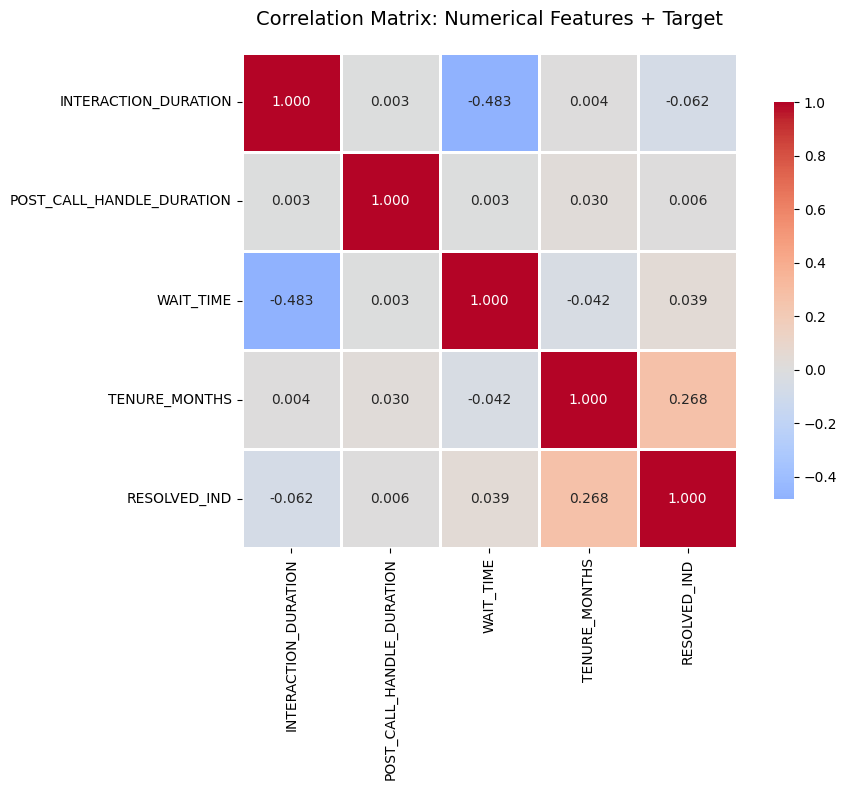

Correlation with Target (RESOLVED_IND):
TENURE_MONTHS                0.267680
WAIT_TIME                    0.038878
POST_CALL_HANDLE_DURATION    0.006280
INTERACTION_DURATION        -0.061855
Name: RESOLVED_IND, dtype: float64


In [22]:
# Feature Correlation Analysis

# Correlation matrix for numerical features
numerical_features = ["INTERACTION_DURATION", "POST_CALL_HANDLE_DURATION", "WAIT_TIME", "TENURE_MONTHS"]
numerical_df = df[numerical_features + [TARGET_COL]]

# Compute Pearson correlation
corr_matrix = numerical_df.corr()

# Visualize correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8},
    ax=ax
)
ax.set_title("Correlation Matrix: Numerical Features + Target", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Display correlation with target
target_corr = corr_matrix[TARGET_COL].drop(TARGET_COL).sort_values(ascending=False)
print("Correlation with Target (RESOLVED_IND):")
print(target_corr)

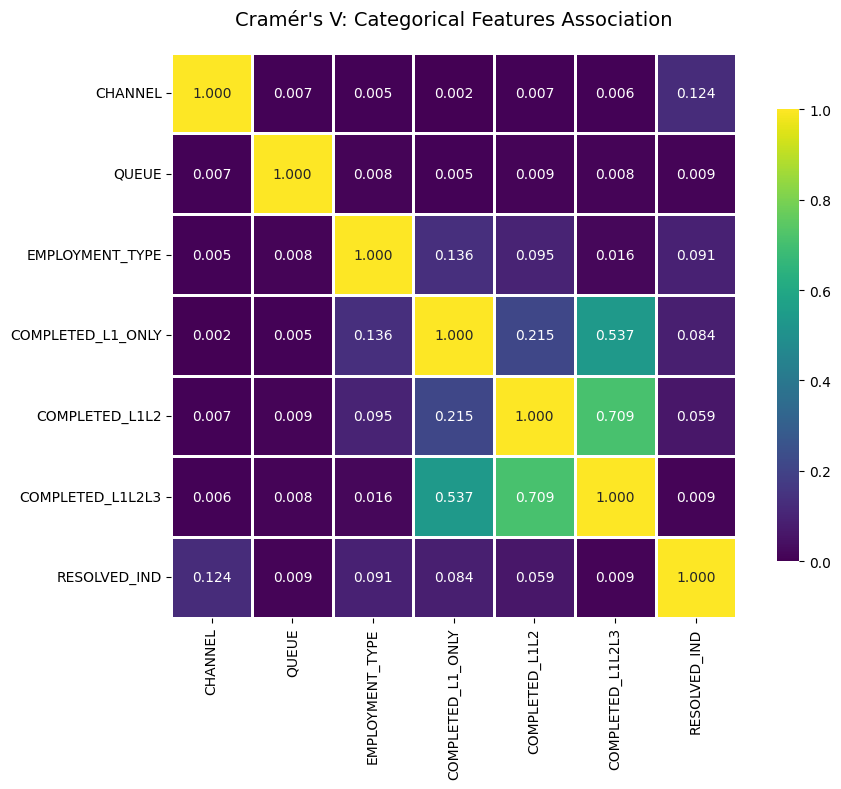


Cramér's V with Target (RESOLVED_IND):
CHANNEL              0.123846
EMPLOYMENT_TYPE      0.090548
COMPLETED_L1_ONLY    0.084001
COMPLETED_L1L2       0.059299
COMPLETED_L1L2L3     0.009432
QUEUE                0.009416
Name: RESOLVED_IND, dtype: float64


In [23]:
# Cramér's V for categorical features - Measures association strength only, always non-negative (no direction)
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    """Calculate Cramér's V statistic for categorical-categorical association."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0

# Compute Cramér's V matrix for categorical features
categorical_features = CATEGORICAL_FEATURES + [TARGET_COL]
categorical_df = df[categorical_features]

cramers_v_matrix = pd.DataFrame(
    index=categorical_features,
    columns=categorical_features,
    dtype=float
)

for col1 in categorical_features:
    for col2 in categorical_features:
        cramers_v_matrix.loc[col1, col2] = cramers_v(
            categorical_df[col1],
            categorical_df[col2]
        )

# Visualize Cramér's V heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    cramers_v_matrix,
    annot=True,
    fmt=".3f",
    cmap="viridis",
    vmin=0,
    vmax=1,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8},
    ax=ax
)
ax.set_title("Cramér's V: Categorical Features Association", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Display association with target
target_cramers = cramers_v_matrix[TARGET_COL].drop(TARGET_COL).sort_values(ascending=False)
print("\nCramér's V with Target (RESOLVED_IND):")
print(target_cramers)

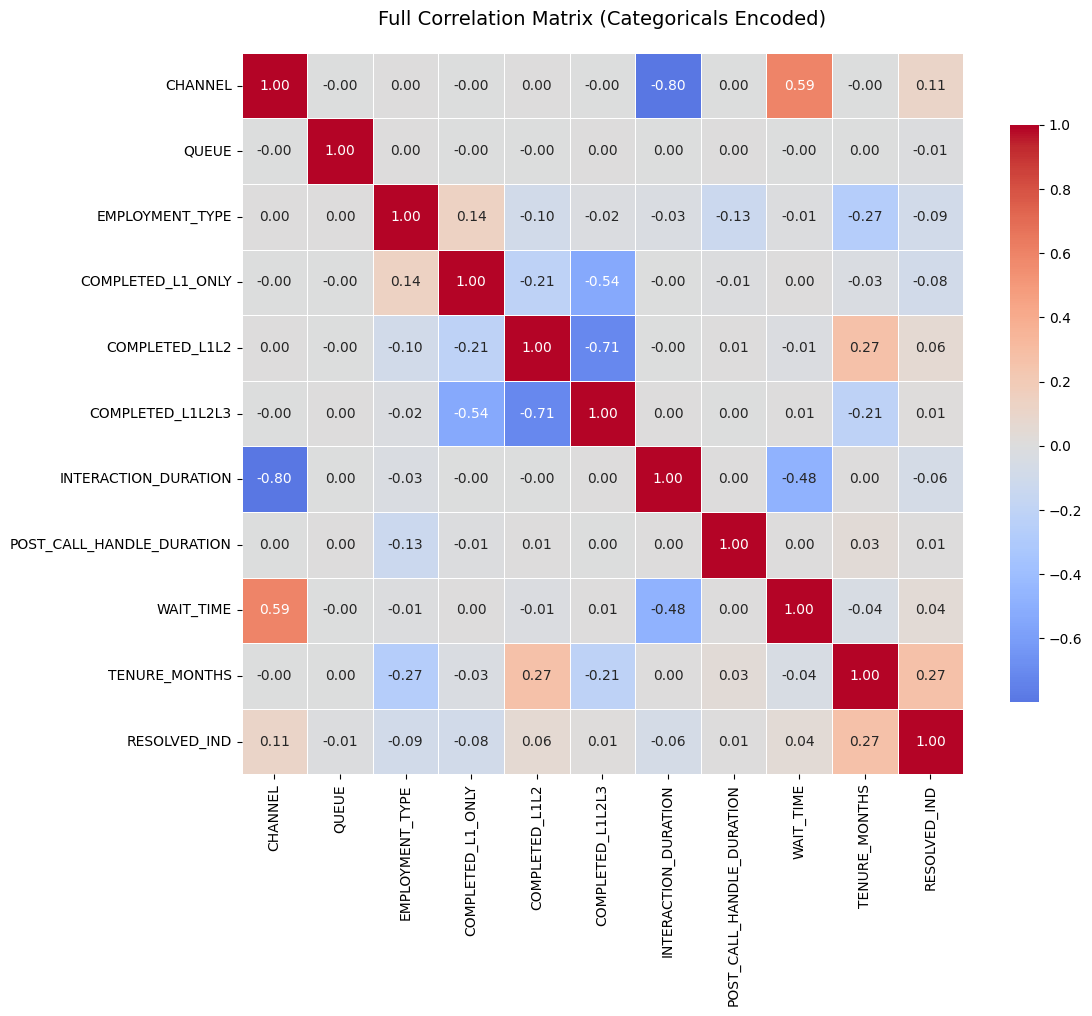


LABEL ENCODINGS FOR CATEGORICAL FEATURES

CHANNEL:
------------------------------------------------------------
  0 = Email
  1 = WebChat
  2 = Whatsapp
  3 = Voice

QUEUE:
------------------------------------------------------------
  0 = Baggage
  1 = Flight Change
  2 = General Inquiries
  3 = Loyalty Program
  4 = New Booking
  5 = Refund

EMPLOYMENT_TYPE:
------------------------------------------------------------
  0 = Outsourced
  1 = Full-time

COMPLETED_L1_ONLY:
------------------------------------------------------------
  0 = False
  1 = True

COMPLETED_L1L2:
------------------------------------------------------------
  0 = False
  1 = True

COMPLETED_L1L2L3:
------------------------------------------------------------
  0 = False
  1 = True

ALL FEATURES CORRELATION WITH TARGET:
TENURE_MONTHS                0.267680
CHANNEL                      0.108195
COMPLETED_L1L2               0.059330
WAIT_TIME                    0.038878
COMPLETED_L1L2L3             0.009459
POST_

In [24]:
from sklearn.preprocessing import LabelEncoder

# Combined correlation summary visualization
# Pearson correlation shows direction and strength (depends on how categories are encoded)
# Prepare data: encode categoricals for correlation
df_encoded = df.copy()
le_dict = {}  # Store label encoders to retrieve mappings

# Define custom encoding orders
CHANNEL_ORDER = ["Email", "WebChat", "Whatsapp", "Voice"]  # Adjust case if needed
EMPLOYMENT_TYPE_ORDER = ["Outsourced", "Full-time"]  # Adjust case if needed

for col in CATEGORICAL_FEATURES:
    if col == "CHANNEL":
        # Use custom order for CHANNEL
        unique_channels = df[col].astype(str).unique()
        channel_order = [ch for ch in CHANNEL_ORDER if ch in unique_channels]
        channel_mapping = {ch: idx for idx, ch in enumerate(channel_order)}
        df_encoded[col] = df[col].astype(str).map(channel_mapping)
        le_dict[col] = channel_mapping
    elif col == "EMPLOYMENT_TYPE":
        # Use custom order for EMPLOYMENT_TYPE
        unique_emp_types = df[col].astype(str).unique()
        emp_order = [emp for emp in EMPLOYMENT_TYPE_ORDER if emp in unique_emp_types]
        emp_mapping = {emp: idx for idx, emp in enumerate(emp_order)}
        df_encoded[col] = df[col].astype(str).map(emp_mapping)
        le_dict[col] = emp_mapping
    else:
        # Use standard LabelEncoder for other categoricals
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df[col].astype(str))
        le_dict[col] = le

# Compute full correlation matrix
all_features = CATEGORICAL_FEATURES + numerical_features
full_corr = df_encoded[all_features + [TARGET_COL]].corr()

# Visualize
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    full_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    ax=ax
)
ax.set_title("Full Correlation Matrix (Categoricals Encoded)", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Display label encodings for categorical features
print("\n" + "="*80)
print("LABEL ENCODINGS FOR CATEGORICAL FEATURES")
print("="*80)
for col in CATEGORICAL_FEATURES:
    print(f"\n{col}:")
    print("-" * 60)
    if col in ["CHANNEL", "EMPLOYMENT_TYPE"]:
        # Display custom mapping
        for label, idx in sorted(le_dict[col].items(), key=lambda x: x[1]):
            print(f"  {idx} = {label}")
    else:
        # Display LabelEncoder mapping
        le = le_dict[col]
        for idx, label in enumerate(le.classes_):
            print(f"  {idx} = {label}")

# Highlight target correlations
print("\n" + "="*80)
print("ALL FEATURES CORRELATION WITH TARGET:")
print("="*80)
target_corr_full = full_corr[TARGET_COL].drop(TARGET_COL).sort_values(ascending=False)
print(target_corr_full)

### **Train Classifier Model to Fit Interactions Dataset**

1. Generate train-test split
2. Fit model with train dataset
3. Generate classification performance report - precision, recall, F1 score and visualise through Confusion Matrix

In [25]:
model_type = "catboost"

if model_type == "catboost":
    # Ensure target is 0/1 for binary classification
    if y.dtype == "object":
        y = y.astype("category").cat.codes  # maps classes to 0,1,...

    # Map categorical feature names to indices for CatBoost
    cat_feature_indices = [X.columns.get_loc(c) for c in CATEGORICAL_FEATURES]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
elif model_type == "random_forest":
    # Ensure target is 0/1 for binary classification
    if y.dtype == "object":
        y = y.astype("category").cat.codes  # maps classes to 0,1,...

    # Encode categorical features for Random Forest
    X_encoded = X.copy()
    label_encoders = {}

    for col in CATEGORICAL_FEATURES:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y, test_size=0.2, random_state=42, stratify=y
    )

In [26]:
if model_type == "catboost":
    train_pool = Pool(X_train, y_train, cat_features=cat_feature_indices)
    test_pool = Pool(X_test, y_test, cat_features=cat_feature_indices)

    from collections import Counter

    # Count classes in training set
    class_counts = Counter(y_train)
    total_samples = len(y_train)
    n_classes = len(class_counts)

    # Calculate balanced weights: n_samples / (n_classes * count_per_class)
    class_weights = [
        total_samples / (n_classes * class_counts[0]),  # Weight for class 0 (False)
        total_samples / (n_classes * class_counts[1])   # Weight for class 1 (True)
    ]

    print(f"Class distribution: {class_counts}")
    print(f"Class weights: {class_weights}")

    model = CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="F1",
        depth=6,
        learning_rate=0.05,
        iterations=500,
        random_seed=42,
        verbose=50,
        class_weights=class_weights,
    )

    model.fit(train_pool, eval_set=test_pool, use_best_model=True)
elif model_type == "random_forest":
    model = RandomForestClassifier(
        n_estimators=500,
        max_depth=6,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1,
        verbose=1,
        class_weight='balanced'  # Optional: helps with imbalanced classes
    )

    model.fit(X_train, y_train)

Class distribution: Counter({True: 42173, False: 22613})
Class weights: [1.432494582762128, 0.7680980722263059]
0:	learn: 0.6711652	test: 0.6743665	best: 0.6743665 (0)	total: 317ms	remaining: 2m 38s
50:	learn: 0.6703346	test: 0.6730299	best: 0.6743665 (0)	total: 9.9s	remaining: 1m 27s
100:	learn: 0.6740216	test: 0.6781912	best: 0.6781939 (99)	total: 19s	remaining: 1m 14s
150:	learn: 0.6752667	test: 0.6792090	best: 0.6794465 (126)	total: 27.7s	remaining: 1m 4s
200:	learn: 0.6761555	test: 0.6780330	best: 0.6794465 (126)	total: 37.4s	remaining: 55.7s
250:	learn: 0.6771931	test: 0.6781038	best: 0.6794465 (126)	total: 47s	remaining: 46.6s
300:	learn: 0.6789992	test: 0.6784353	best: 0.6794465 (126)	total: 57.1s	remaining: 37.8s
350:	learn: 0.6800775	test: 0.6779297	best: 0.6794465 (126)	total: 1m 8s	remaining: 28.9s
400:	learn: 0.6814200	test: 0.6780086	best: 0.6794465 (126)	total: 1m 19s	remaining: 19.6s
450:	learn: 0.6824682	test: 0.6786281	best: 0.6794465 (126)	total: 1m 31s	remaining: 9.

In [27]:
if model_type == "catboost":
    y_pred_proba = model.predict_proba(test_pool)[:, 1]
    y_pred = (y_pred_proba >= 0.5).astype(int)

    print("Test ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
    print("\nClassification report:\n")
    print(classification_report(y_test, y_pred))
elif model_type == "random_forest":
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= 0.5).astype(int)

    print("Test ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
    print("\nClassification report:\n")
    print(classification_report(y_test, y_pred))

Test ROC-AUC: 0.7323353154687386

Classification report:

              precision    recall  f1-score   support

       False       0.53      0.68      0.60      5654
        True       0.80      0.68      0.73     10543

    accuracy                           0.68     16197
   macro avg       0.66      0.68      0.67     16197
weighted avg       0.70      0.68      0.69     16197



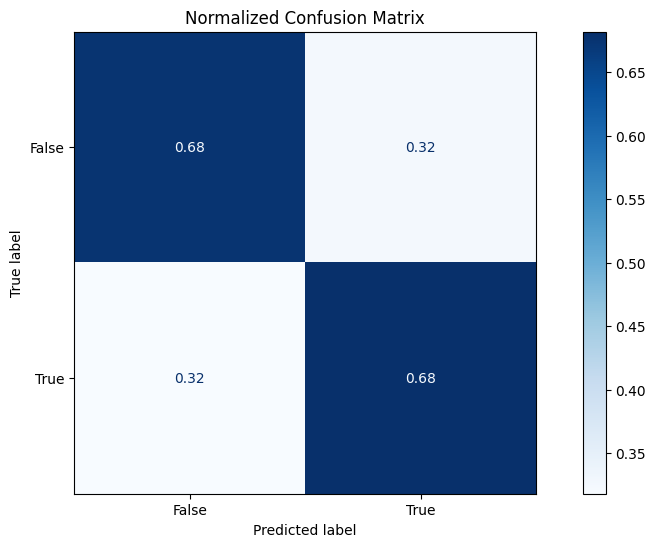

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(12, 6))

disp_norm = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    cmap="Blues",
    normalize="true",
    ax=ax
)

ax.set_title("Normalized Confusion Matrix")
plt.show()

### **Visualise Feature Importance**

1. Generate feature importance for CatBoost model
2. Generate permutation feature importance to measure how much the model’s performance drops when randomly shuffle one feature at a time


In [29]:
if model_type == "catboost":
    cb_importance = model.get_feature_importance(train_pool, type="PredictionValuesChange")
    feat_imp_cb = pd.DataFrame({
        "feature": X.columns,
        "cb_importance": cb_importance
    }).sort_values("cb_importance", ascending=False)

    print(feat_imp_cb)
elif model_type == "random_forest":
    rf_importance = model.feature_importances_
    feat_imp_rf = pd.DataFrame({
        "feature": X_train.columns,
        "rf_importance": rf_importance
    }).sort_values("rf_importance", ascending=False)

    print(feat_imp_rf)

                     feature  cb_importance
9              TENURE_MONTHS      59.403867
6       INTERACTION_DURATION      15.269738
7  POST_CALL_HANDLE_DURATION       8.428783
8                  WAIT_TIME       6.020567
0                    CHANNEL       3.265832
1                      QUEUE       2.455145
3          COMPLETED_L1_ONLY       1.852035
5           COMPLETED_L1L2L3       1.235583
2            EMPLOYMENT_TYPE       1.140111
4             COMPLETED_L1L2       0.928338


In [30]:
from sklearn.metrics import make_scorer

# Use ROC-AUC as scoring
scorer = "roc_auc"

pi_result = permutation_importance(
    model,
    X_test,
    y_test,
    n_repeats=20,
    random_state=42,
    scoring=scorer,
)

feat_imp_pi = pd.DataFrame({
    "feature": X_test.columns,
    "pi_importance_mean": pi_result.importances_mean,
    "pi_importance_std": pi_result.importances_std,
}).sort_values("pi_importance_mean", ascending=False)

feat_imp_pi

,feature,pi_importance_mean,pi_importance_std
9,TENURE_MONTHS,0.202921,0.004351
6,INTERACTION_DURATION,0.011831,0.000952
8,WAIT_TIME,0.003905,0.000555
0,CHANNEL,0.003211,0.000668
3,COMPLETED_L1_ONLY,0.002128,0.000408
5,COMPLETED_L1L2L3,0.000244,0.000166
2,EMPLOYMENT_TYPE,0.000139,0.000166
4,COMPLETED_L1L2,0.000109,0.000164
1,QUEUE,0.000009,0.000184
7,POST_CALL_HANDLE_DURATION,-0.000694,0.000538


### Visualise Feature Contribution to Model Prediction using SHAP Values

1. Generate SHAP summary plot to visualise strength and direction of feature impact on prediction outcome
2. Generate Partial Dependence Plots to study how changing a single feature affects the model’s predicted outcome, while averaging out the effect of all other features - doing this for the top 4 features

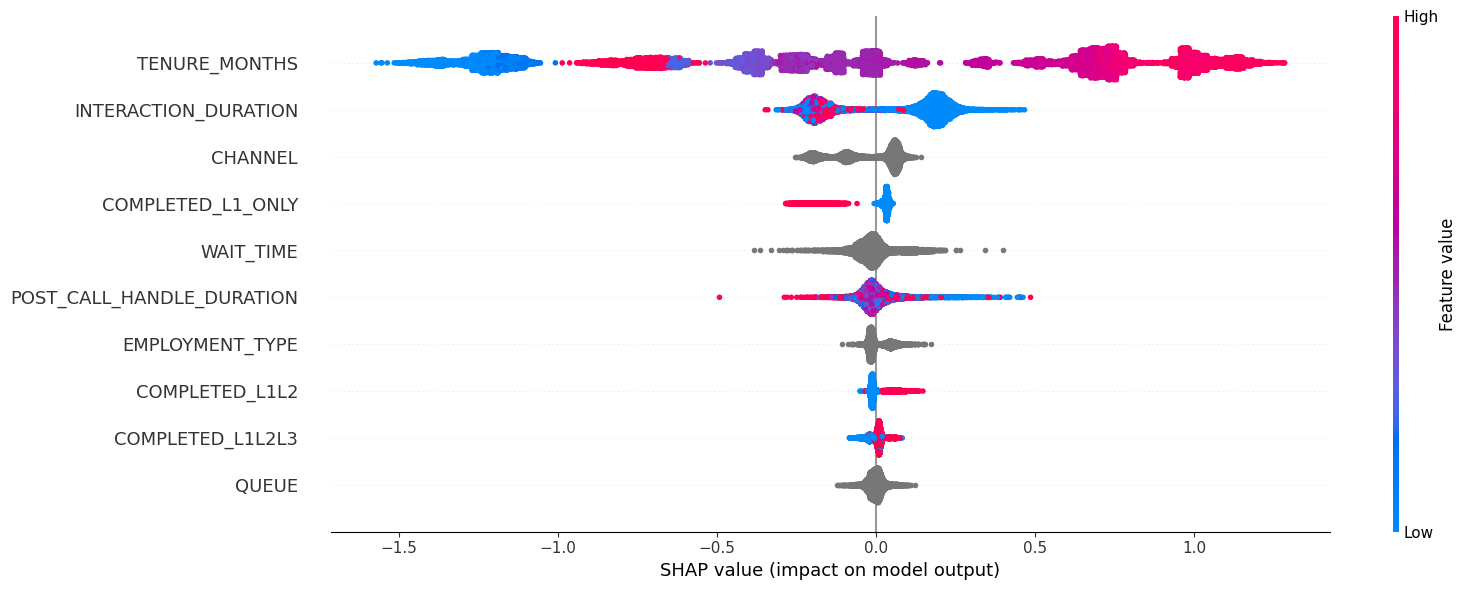

In [31]:
X_shap = X_test.copy()

if model_type == "catboost":
    pool_shap = Pool(X_shap, cat_features=cat_feature_indices)

    shap_values = model.get_feature_importance(
        pool_shap, 
        type="ShapValues"
    )

    # For binary classification, last column is base value; others are feature SHAPs
    # shap_values shape: (n_samples, n_features + 1)
    shap_values_feat = shap_values[:, :-1]  # drop bias term
    expected_value = shap_values[:, -1].mean()

    explainer = shap.TreeExplainer(model)

    # Global summary (beeswarm)
    shap.summary_plot(
        shap_values_feat,
        X_shap,
        plot_size=(16, 6),
        show=True
    )
elif model_type == "random_forest":
    # Create SHAP explainer for Random Forest
    explainer = shap.TreeExplainer(model)

    # Calculate SHAP values
    shap_values = explainer.shap_values(X_shap)

    # For binary classification, shap_values is a list with one array per class
    # We want the positive class (index 1) for binary classification
    if isinstance(shap_values, list):
        shap_values_feat = shap_values[1]  # Use positive class SHAP values
    else:
        shap_values_feat = shap_values  # If single array, use as is

    expected_value = explainer.expected_value
    # For binary classification, expected_value might be an array
    if isinstance(expected_value, np.ndarray):
        expected_value = expected_value[1]  # Use positive class expected value

    # Global summary (beeswarm)
    shap.summary_plot(
        shap_values_feat,
        X_shap,
        plot_size=(16, 6),
        show=True
    )

In [32]:
mean_abs_shap = np.abs(shap_values_feat).mean(axis=0)

feat_imp_shap = pd.DataFrame({
    "feature": X_shap.columns,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

feat_imp_shap

,feature,mean_abs_shap
9,TENURE_MONTHS,0.687471
6,INTERACTION_DURATION,0.184063
0,CHANNEL,0.088795
3,COMPLETED_L1_ONLY,0.055113
8,WAIT_TIME,0.039692
7,POST_CALL_HANDLE_DURATION,0.035537
2,EMPLOYMENT_TYPE,0.026765
4,COMPLETED_L1L2,0.021851
5,COMPLETED_L1L2L3,0.015579
1,QUEUE,0.015577


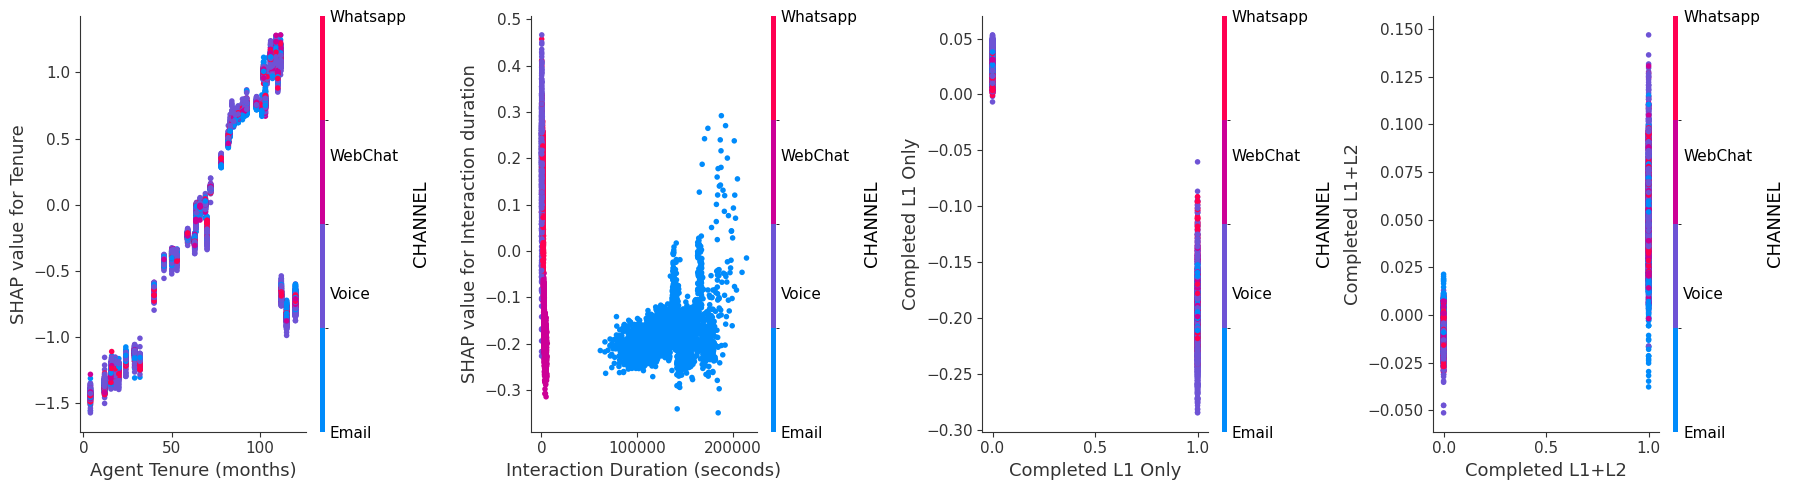

In [33]:
features_to_plot = ["TENURE_MONTHS", "INTERACTION_DURATION", "COMPLETED_L1_ONLY", "COMPLETED_L1L2"]
x_labels = {
    "TENURE_MONTHS": "Agent Tenure (months)",
    "INTERACTION_DURATION": "Interaction Duration (seconds)",
    "COMPLETED_L1_ONLY": "Completed L1 Only",
    "COMPLETED_L1L2": "Completed L1+L2",
}
y_labels = {
    "TENURE_MONTHS": "SHAP value for Tenure",
    "INTERACTION_DURATION": "SHAP value for Interaction duration",
    "COMPLETED_L1_ONLY": "Completed L1 Only",
    "COMPLETED_L1L2": "Completed L1+L2",
}

fig, axes = plt.subplots(1, 4, figsize=(18, 5))

for ax, f in zip(axes, features_to_plot):
    shap.dependence_plot(
        f,
        shap_values_feat,
        X_shap,
        interaction_index="CHANNEL",
        ax=ax,
        show=False
    )
    
    # Rename x & y axes
    ax.set_xlabel(x_labels.get(f, f))
    ax.set_ylabel(y_labels.get(f, f"SHAP value for {f}"))

plt.tight_layout()
plt.show()

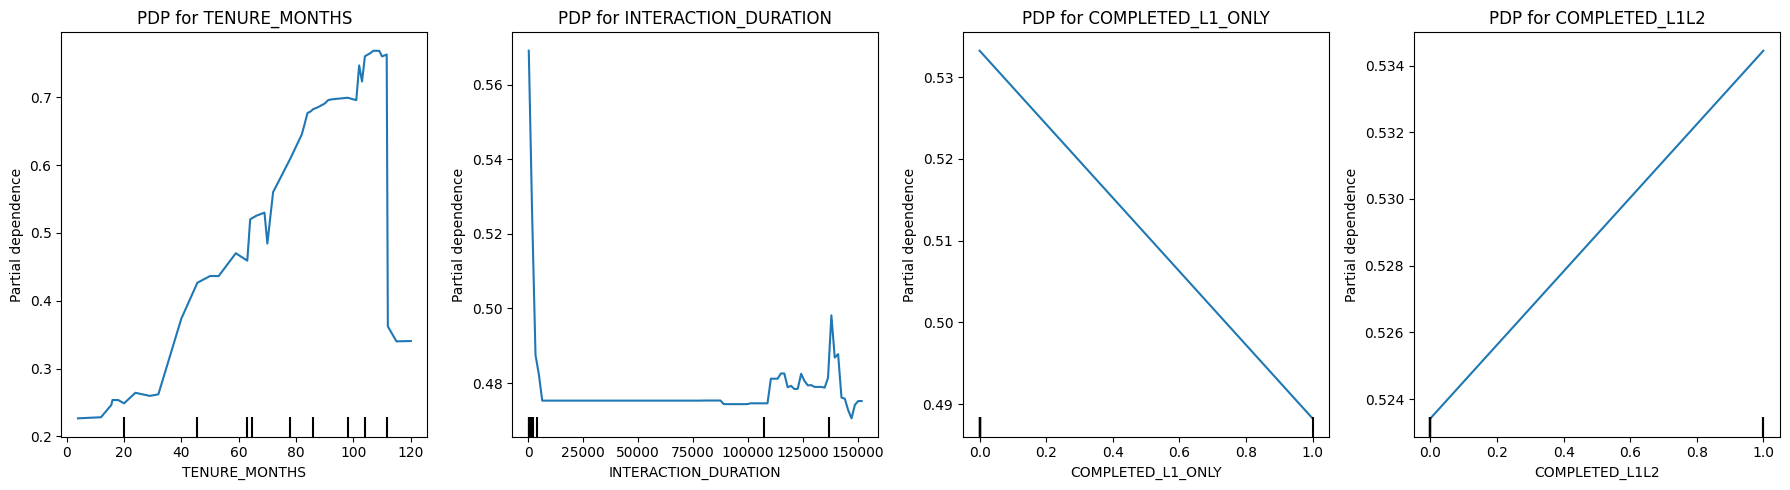

In [34]:
# Convert X_test to handle Decimal types and None values
X_test_clean = X_test.copy()

# Convert all numeric columns to float (handles Decimal types)
for col in X_test_clean.columns:
    if col not in CATEGORICAL_FEATURES and col != '':
        # Convert to numeric, coercing errors to NaN
        X_test_clean[col] = pd.to_numeric(X_test_clean[col], errors='coerce')

# Ensure all numeric columns are float
numeric_cols = X_test_clean.select_dtypes(include=[np.number]).columns
X_test_clean[numeric_cols] = X_test_clean[numeric_cols].astype(float)

fig, axes = plt.subplots(1, 4, figsize=(18, 5))

for ax, f in zip(axes, features_to_plot):
    PartialDependenceDisplay.from_estimator(
        model,
        X_test_clean,
        [f],
        kind="average",
        ax=ax
    )
    ax.set_title(f"PDP for {f}")

plt.tight_layout()
plt.show()

Channel: WebChat


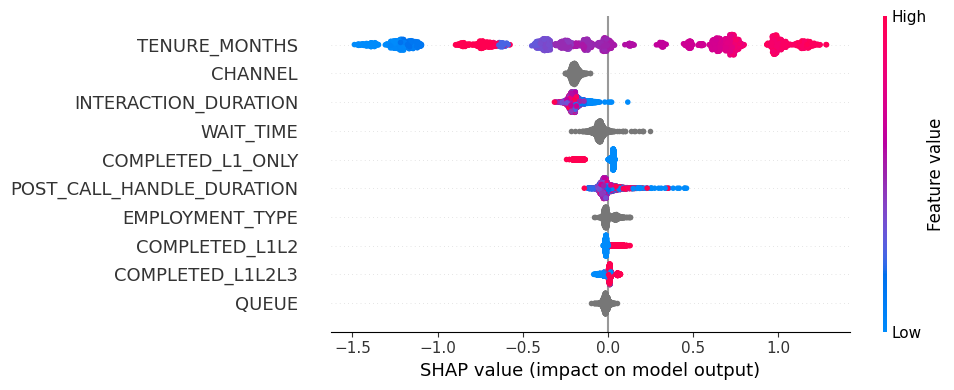

Channel: Whatsapp


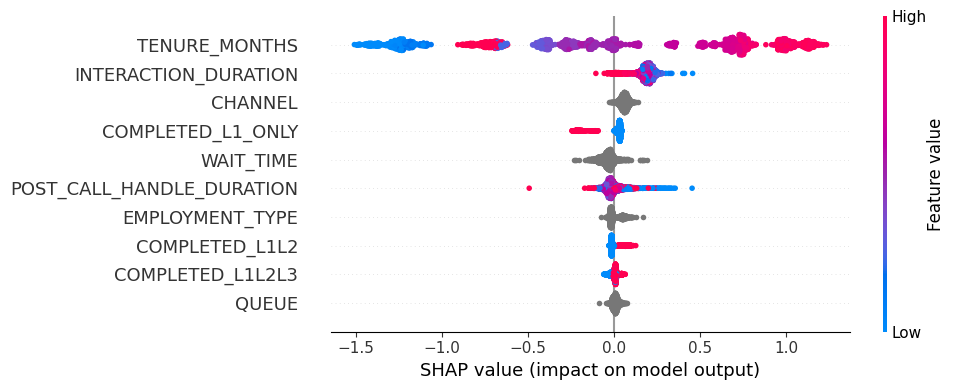

Channel: Voice


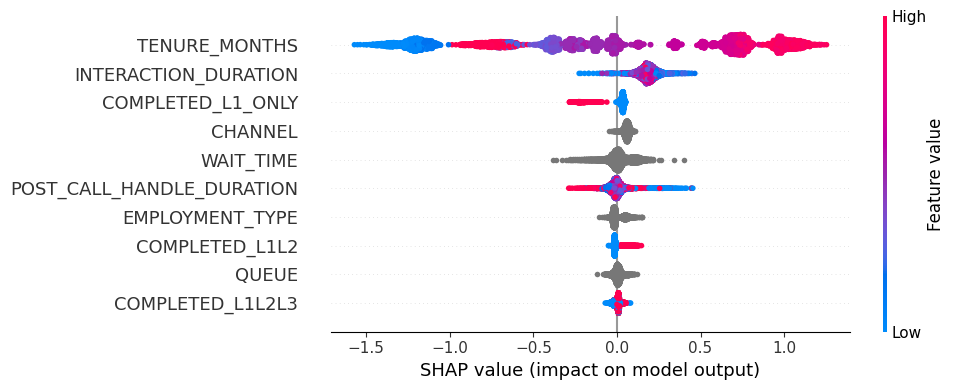

Channel: Email


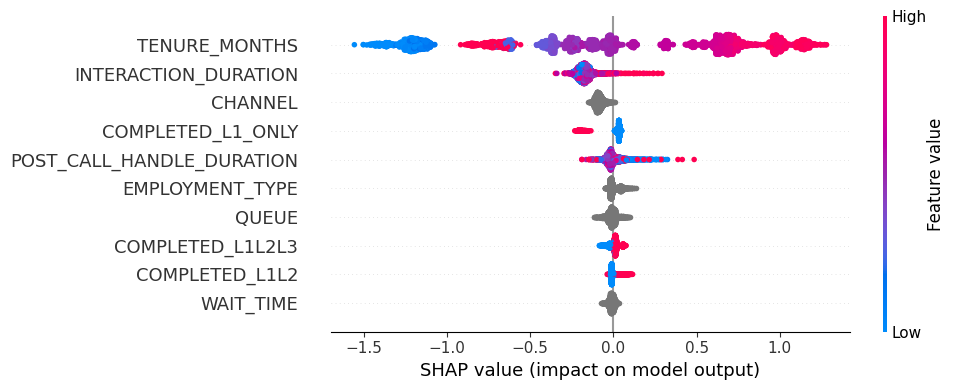

In [35]:
unique_channels = X_shap['CHANNEL'].unique()

for q in unique_channels:
    mask = X_shap['CHANNEL'] == q
    X_q = X_shap[mask]
    
    pool_q = Pool(X_q, cat_features=cat_feature_indices)
    shap_vals_q = model.get_feature_importance(pool_q, type="ShapValues")
    shap_vals_q_feat = shap_vals_q[:, :-1]
    
    print(f"Channel: {q}")
    shap.summary_plot(
        shap_vals_q_feat,
        X_q,
        plot_size=(10, 4),
        show=True
    )

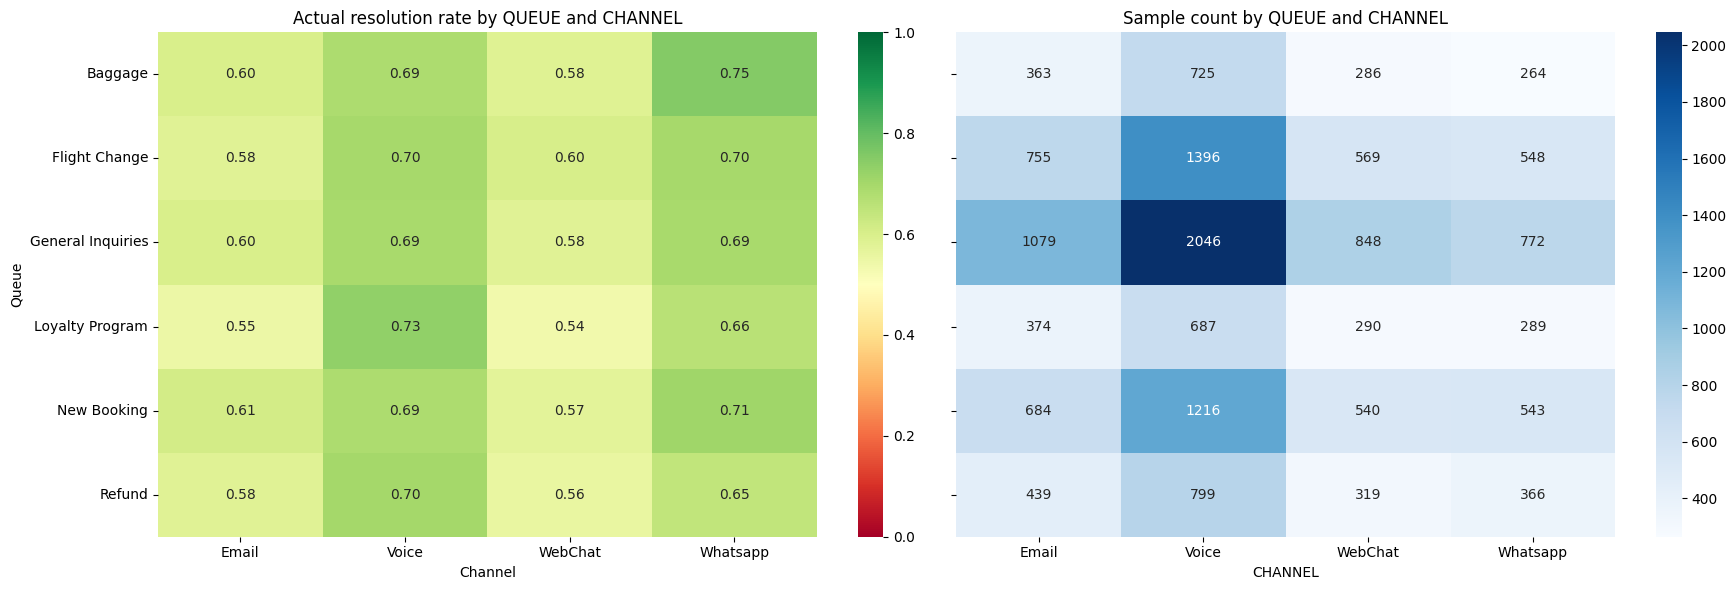

In [36]:

# X_shap should be aligned with y (the true labels)
df_actual = X_shap.copy()
df_actual['resolved'] = y_test.values

agg_actual = (
    df_actual
    .groupby(['QUEUE', 'CHANNEL'])['resolved']
    .agg(resolution_rate='mean', count='count')
    .reset_index()
)

heatmap_actual = agg_actual.pivot(index='QUEUE', columns='CHANNEL', values='resolution_rate')
count_actual   = agg_actual.pivot(index='QUEUE', columns='CHANNEL', values='count')

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharex=True, sharey=True)

# Left: actual resolution rate
sns.heatmap(
    heatmap_actual,
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    vmin=0.0, vmax=1.0,
    ax=axes[0]
)
axes[0].set_title("Actual resolution rate by QUEUE and CHANNEL")
axes[0].set_xlabel("Channel")
axes[0].set_ylabel("Queue")

# Right: sample count
sns.heatmap(
    count_actual,
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=axes[1]
)
axes[1].set_title("Sample count by QUEUE and CHANNEL")
axes[1].set_xlabel("CHANNEL")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()